In [1]:
import numpy as np
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from simulation_utils.utils import compute_user_activity
from simulation_utils.utils import beta_binomial

%matplotlib inline

In [2]:
data = pd.read_csv('data/ml-100k/u.data', names=['user', 'item', 'rating', 'timestamp'], sep='\t')

In [3]:
nprofile = data.groupby('user')['item'].count().values

In [4]:
nusers = len(nprofile)

In [31]:
# pareto_sampling = """
# data {
#     int<lower=1> N;
#     vector<lower=20>[N] y;
# }
# parameters {
#     real<lower=20> m;
#     real<lower=0> alpha;
#     vector<lower=-0.5, upper=0.5>[N] y_err;
    
# }
# transformed parameters {
#     vector[N] z;
#     z = y + y_err;
# }
# model {
#     target += -0.001*m -0.001*alpha + log(0.002);
#     z ~ pareto(m, alpha);
# }
# """
# sm = pystan.StanModel(model_code=pareto_sampling)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f12edbeb268d4ab88610b9aba24443e NOW.


In [5]:
pareto_code = """
data {
    int<lower=1> N;
    int<lower=20> y[N];
}
transformed data {
    int<lower=1> y_max;
    y_max = max(y);
}
parameters {
    real<lower=20> m;
    real<lower=0> alpha;
}
model {
    m ~ normal(20, 10);
    alpha ~ exponential(0.1);
    for (n in 1:N) {
        target += log(pareto_cdf((y[n] + 0.5), m, alpha) - pareto_cdf((y[n] - 0.5), m, alpha));
        if (y[n] > y_max)
            target += negative_infinity();
        else
            target += -pareto_lcdf(y_max | m, alpha);
    }
}
"""

In [6]:
beta_binomial_code = """
data {
    int<lower=1> N;
    int<lower=20> y[N];
}
transformed data {
    int<lower=1> y_max;
    y_max = max(y);
}
parameters {
    real<lower=0> a;
    real<lower=0> b;
}
model {
    a ~ exponential(0.1);
    b ~ exponential(0.1);
    for (n in 1:N)
        y[n] ~ beta_binomial(y_max, a, b) T[20, ];
}
generated quantities {
    int y_pred[N];
    for (n in 1:N){
        y_pred[n] = beta_binomial_rng(y_max, a, b);
        while (y_pred[n] < 20)
            y_pred[n] = beta_binomial_rng(y_max, a, b);
    }      
}
"""

In [7]:
truncated_poisson_code = """
data {
    int<lower=1> N;
    int<lower=20> y[N];
}
parameters {
    real<lower=0> lambda;
}
model {
    y ~ poisson(lambda);
    for (n in 1:N)
        if (y[n] < 20)
            target += negative_infinity();
        else
            target += -log_sum_exp(poisson_lpmf(20 | lambda),
                                   poisson_lccdf(20 | lambda));
}
"""

In [8]:
def compile_stan_model(model_code, model_name, model_dir='build', **kwargs):
    import os
    import pickle
    fn = '.'.join([model_name, 'pkl'])
    fdir = os.path.join(model_dir, fn)
    try:
        with open(fdir, 'rb') as f:
            sm = pickle.load(f)
    except:
        sm = pystan.StanModel(model_code=model_code, model_name=model_name, **kwargs)
        with open(fdir, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print('Load compiled model')
    return sm

In [9]:
sm = compile_stan_model(pareto_code, 'pareto')

Load compiled model


In [10]:
model_data = {'N': nusers,
              'y': nprofile}

In [11]:
op = sm.optimizing(data=model_data)

In [12]:
op

OrderedDict([('m', array(20.00000045)), ('alpha', array(0.510528))])

In [13]:
def truncated_beta_binomial(a, b, n, size=None, lower=20):
    out = beta_binomial(a, b, n, size)
    outliers = out < lower
    while any(outliers):
        ndraws = np.count_nonzero(outliers)
        out[outliers] = beta_binomial(a, b, n, ndraws)
        outliers = out < lower
    return out

In [14]:
def truncated_pareto(m, alpha, size=None, upper=737):
    from scipy.stats import pareto
    p = pareto.cdf(upper, alpha, scale=m)
    u = np.random.uniform(0, p, size)
    y = m / ((1 - u) ** (1 / alpha))
    return y

In [15]:
generated_pareto = truncated_pareto(op['m'], op['alpha'], size=nusers).astype(np.int64)

In [16]:
sm = compile_stan_model(beta_binomial_code, 'beta_binomial')

Load compiled model


In [17]:
op = sm.optimizing(data=model_data)

In [18]:
print(op['a'], op['b'])

1.6638872003071793e-05 2.8157887296158077


In [19]:
generated_bb = truncated_beta_binomial(op['a'], op['b'], np.max(nprofile), nusers)

In [20]:
data = pd.DataFrame({'ml_100k': nprofile, 'beta_binomial': generated_bb, 'pareto': generated_pareto}).melt(var_name='dataset', value_name='size')

/home/MucunTian/anaconda3/envs/eval-err/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


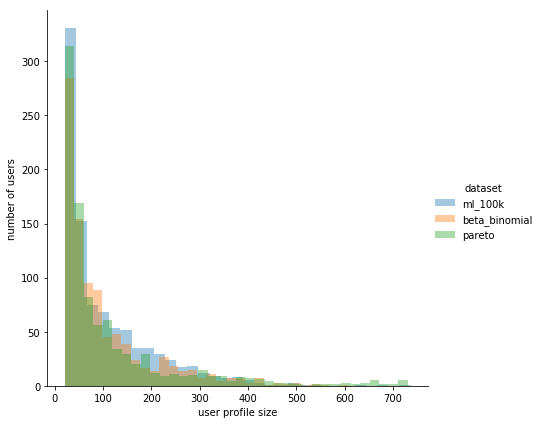

In [23]:
g = sns.FacetGrid(data, hue='dataset', size=6)
g = (g.map(sns.distplot, 'size', kde=False)
     .add_legend()
     .set_axis_labels('user profile size', 'number of users'))